# QEC 测试

In [1]:
%run ../qsu.ipynb  # color-printing functions
import numpy as np
from qecsim import paulitools as pt
from qecsim.models.generic import DepolarizingErrorModel, BitFlipErrorModel, PhaseFlipErrorModel
from qecsim.models.planar import PlanarCode, PlanarMWPMDecoder, PlanarMPSDecoder
from phase_flip_ti import ti_calc_jax, ti_calc_jax_op


# initialise models
d = 7
my_code = PlanarCode(d, d)
my_error_model = PhaseFlipErrorModel()
#my_decoder = PlanarMWPMDecoder()
# print models
print(my_code)
print(my_error_model)
#print(my_decoder)

PlanarCode(7, 7)
PhaseFlipErrorModel()


In [2]:
# set physical error probability to 10%
error_probability = 0.1
# seed random number generator for repeatability
rng = np.random.default_rng(1111)

# error: random error based on error probability
error = my_error_model.generate(my_code, error_probability, rng)
qsu.print_pauli('error:\n{}'.format(my_code.new_pauli(error)))

In [3]:
# syndrome: stabilizers that do not commute with the error
syndrome = pt.bsp(error, my_code.stabilizers.T)
qsu.print_pauli('syndrome:\n{}'.format(my_code.ascii_art(syndrome)))

## 生成Recovery

In [4]:
# from mps decoder
my_mps_decoder = PlanarMPSDecoder(chi=6)
coset_ps, recoveries = my_mps_decoder.calc_coset_probabilities(
    my_code,
    syndrome,
    error_model=my_error_model,
    error_probability=error_probability)

print('total prob of each coset', coset_ps)
print('Only the first and last are non-zero because only Z errors.')
print('The log of their ratio is:',
      np.log(float(coset_ps[3]) / float(coset_ps[0])))

total prob of each coset (mpf('1.5758944953105232e-11'), mpf('0.0'), mpf('0.0'), mpf('2.6072957444614728e-12'))
Only the first and last are non-zero because only Z errors.
The log of their ratio is: -1.7990945666238425


In [5]:
recovery = recoveries[0].to_bsf()
print(recovery)
qsu.print_pauli('recovery:\n{}'.format(my_code.new_pauli(recovery)))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [6]:
# success iff recovery ^ error commutes with logicals
print(pt.bsp(recovery ^ error, my_code.logicals.T))

[0 0]


In [7]:
# couriosity:recovery ^ error
qsu.print_pauli('recovery ^ error:\n{}'.format(my_code.new_pauli(recovery ^ error)))

In [8]:
ti_calc_jax_op(recovery, 
                error_probability=error_probability, 
                d=d, 
                num_int_steps=101,
                mcmove_steps_init=500000, 
                mcmove_steps_for_derivative=1000,
                num_samples=1000)

(Array(-1.8002079, dtype=float32), Array(0.01726119, dtype=float32))

## TI_JAX测试

In [10]:
import jax
print(jax.devices())

[CpuDevice(id=0)]


In [11]:
mean_integral, error_bar, states_record, h_borders, v_borders=ti_calc_jax(recovery,
                     error_probability=error_probability,
                     d=d,
                     num_int_steps=101,
                     mcmove_steps_init = 500000, 
                     mcmove_steps_for_derivative=1000, 
                     num_samples=1000,  
                     animation_step=0)
print(mean_integral, error_bar)

l = 0.000, energy derivative = -13.4920, spin flip ratio = 0.058
l = 0.010, energy derivative = -13.3520, spin flip ratio = 0.057
l = 0.020, energy derivative = -13.2800, spin flip ratio = 0.058
l = 0.030, energy derivative = -13.2320, spin flip ratio = 0.058
l = 0.040, energy derivative = -13.2960, spin flip ratio = 0.057
l = 0.050, energy derivative = -13.2080, spin flip ratio = 0.059
l = 0.060, energy derivative = -13.2560, spin flip ratio = 0.059
l = 0.070, energy derivative = -13.0520, spin flip ratio = 0.059
l = 0.080, energy derivative = -12.9880, spin flip ratio = 0.060
l = 0.090, energy derivative = -13.0400, spin flip ratio = 0.060
l = 0.100, energy derivative = -12.8680, spin flip ratio = 0.060
l = 0.110, energy derivative = -12.8200, spin flip ratio = 0.061
l = 0.120, energy derivative = -12.6760, spin flip ratio = 0.061
l = 0.130, energy derivative = -12.5800, spin flip ratio = 0.061
l = 0.140, energy derivative = -12.4760, spin flip ratio = 0.061
l = 0.150, energy derivat

In [12]:
len(states_record)

500000

In [13]:
print(h_borders)
print(v_borders)

[[ 1.  1.  1.  1.  1. -1. -1.]
 [ 1.  1.  1.  1.  1. -1. -1.]
 [-1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1. -1.  1.  1.]
 [ 1.  1.  1.  1. -1. -1. -1.]
 [-1.  1. -1.  1. -1. -1. -1.]
 [-1. -1.  1.  1.  1.  1. -1.]]
[[1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]
 [1 1 1 1 1 1]]


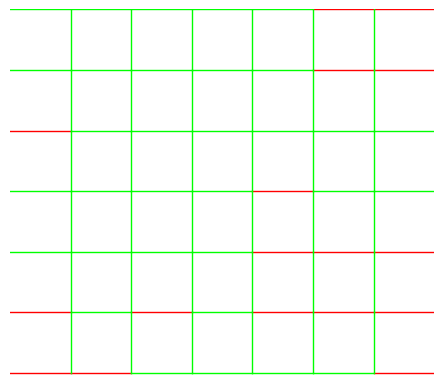

In [14]:
from animation import create_grid_with_colored_borders_alone
create_grid_with_colored_borders_alone(d, h_borders, v_borders)

In [19]:
states_vedio= states_record[-1000:]

In [20]:
from animation import create_spin_animation
create_spin_animation(d, h_borders, v_borders, states_vedio, 'spin_animation_7_l_0.mp4')

In [58]:
print(states_vedio[-1])

[[ 1  1  1  1  1  1  1  1]
 [ 1  1  1  1  1  1  1 -1]
 [-1 -1 -1  1  1  1  1  1]
 [ 1 -1 -1 -1  1  1  1  1]
 [ 1 -1 -1  1  1  1  1  1]
 [ 1  1  1  1  1  1  1  1]
 [-1 -1 -1  1  1  1  1  1]]
